# Clustering with K-Means Algorithm

<font face = "Verdana" size = "+1"><strong>Individual Household Electric Power Consumption</strong></font><br><br>
<font face = "Verdana" size = "+0"> Households make use of electricity for several reasons ranging from heating, refrigirating, electronics and so on.<br> In this project, we'll make use of the K-Means clustering algorithm to model the relationships between the  electric power consumption in households


# Prepare Data

## Import

**Task 1:** Import all necessary libraries

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import trimmed_var
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

warnings.filterwarnings(action = "ignore")

**Task 2:** Create a wrangle function to clean the dataset

In [97]:
def wrangle(filepath, separator):
    df = pd.read_csv(filepath, sep = separator)
    
    #Subset date
    df['Date'] = pd.DatetimeIndex(df['Date']).year
    
    #Subset dataframe
    df = df[df['Global_active_power'] != "?"]
    df = df[df["Date"] == 2008]
    
    #Reset index
    df = df.reset_index()
    
    #Drop the 'redundant' columns
    df.drop(columns = ["Time", "Date", "index"], inplace = True)
    
    #Recast datatype
    df[df.select_dtypes("object").columns.to_list()] =df[df.select_dtypes("object").columns.to_list()].astype(float)
    
    return df
    
df = wrangle("household_power_consumption.txt", ';')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1.620,0.070,241.250,6.600,0.000,0.000,18.0
1,1.626,0.072,241.740,6.600,0.000,0.000,18.0
2,1.622,0.072,241.520,6.600,0.000,0.000,18.0
3,1.612,0.070,240.820,6.600,0.000,0.000,18.0
4,1.612,0.070,240.800,6.600,0.000,0.000,18.0


**Task 3:** Inspect dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526905 entries, 0 to 526904
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    526905 non-null  float64
 1   Global_reactive_power  526905 non-null  float64
 2   Voltage                526905 non-null  float64
 3   Global_intensity       526905 non-null  float64
 4   Sub_metering_1         526905 non-null  float64
 5   Sub_metering_2         526905 non-null  float64
 6   Sub_metering_3         526905 non-null  float64
dtypes: float64(7)
memory usage: 28.1 MB


**Task 4:** Check presence of unwanted character(s)

In [96]:
(df[["Global_reactive_power","Global_active_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2"]][df['Global_active_power'] == "?"]).value_counts()

Global_reactive_power  Global_active_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2
?                      ?                    ?        ?                 ?               ?                 135
dtype: int64

**Task 5:** Recast datatype

In [94]:
df[df.select_dtypes("object").columns.to_list()].astype(float)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,1.620,0.070,241.25,6.6,0.0,0.0
1,1.626,0.072,241.74,6.6,0.0,0.0
2,1.622,0.072,241.52,6.6,0.0,0.0
3,1.612,0.070,240.82,6.6,0.0,0.0
4,1.612,0.070,240.80,6.6,0.0,0.0
...,...,...,...,...,...,...
526900,0.484,0.064,247.69,2.2,0.0,0.0
526901,0.482,0.064,247.35,2.2,0.0,0.0
526902,0.482,0.064,246.99,2.2,0.0,0.0
526903,0.480,0.064,246.52,2.2,0.0,0.0


## Explore

**Task 6:** Calculate the variance of the features in the dataset

In [6]:
df_var = df.var()
df_var

Global_active_power       1.135062
Global_reactive_power     0.011998
Voltage                   8.239426
Global_intensity         20.126134
Sub_metering_1           37.706184
Sub_metering_2           33.631157
Sub_metering_3           67.677487
dtype: float64

**Task 7:** Visualize the variance

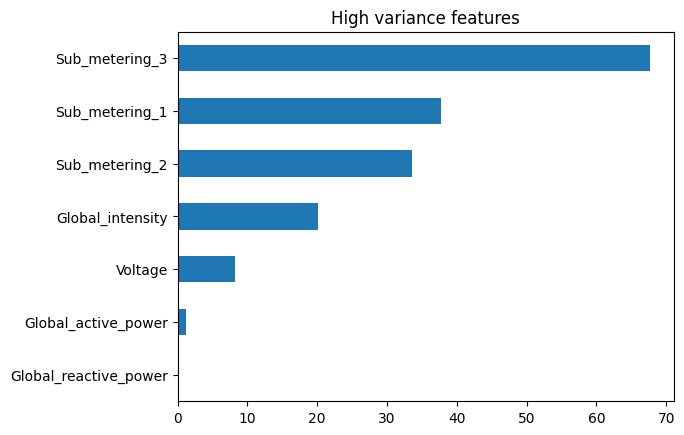

In [102]:
df_var.sort_values().tail(10).plot(kind = "barh")
plt.title("High variance features");

**Task 8:** Check the presence of outliers

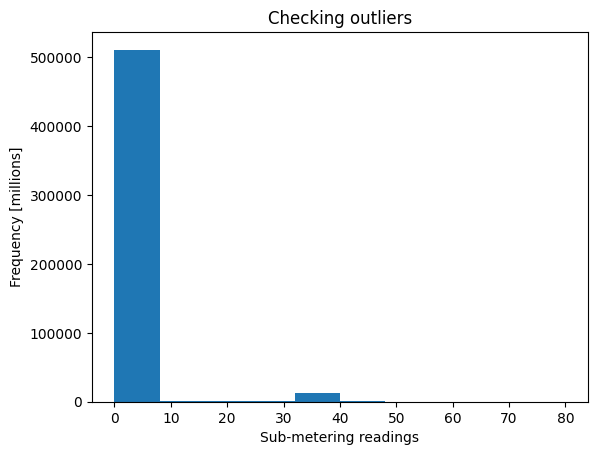

In [8]:
plt.hist(df["Sub_metering_1"])
plt.title("Checking outliers")
plt.xlabel("Sub-metering readings")
plt.ylabel("Frequency [millions]");

**Comment:** The presence of outliers would affect the measures of variance

**Task 9:** Calculate the trimmed variance

In [9]:
df_trimmed_var = df.apply(trimmed_var, limits = (0.1, 0.1))
df_trimmed_var.sort_values(ascending = False)

Sub_metering_3           56.678934
Global_intensity          6.854951
Voltage                   3.293423
Global_active_power       0.402248
Sub_metering_2            0.198340
Global_reactive_power     0.005299
Sub_metering_1            0.000000
dtype: float64

**Task 10:** Visualize the trimmed variance

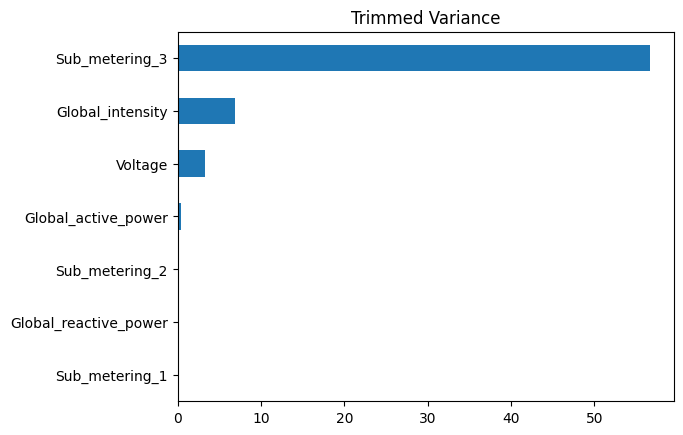

In [101]:
df_trimmed_var.sort_values(ascending = True).plot(kind = "barh")
plt.title("Trimmed Variance");

**Task 11:** Get the top two features with the highest variance

In [58]:
high_cor = df_trimmed_var.tail().sort_values(ascending = False).index.to_list()[:2]
high_cor

['Sub_metering_3', 'Global_intensity']

## Explore

**Task 12:** Create a split

In [59]:
X = df[high_cor]

**Task 13:** Create a random split of the initial spliit

In [60]:
X, X_discarded = train_test_split(
    X, test_size = 0.97, random_state = 2
)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15807 entries, 394808 to 100879
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sub_metering_3    15807 non-null  float64
 1   Global_intensity  15807 non-null  float64
dtypes: float64(2)
memory usage: 370.5 KB


**Comment :** The task 13 might not be needed when running this notebook on a machine with higher configuration

# Build Model

# Iterate

**Task 14 :** Build K-Means model for clusters 2 to 10

In [61]:
n_clusters = range(2, 10)
inertia = []
ss_score = []
for n in n_clusters:
    model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters = n, random_state = 15)
    )
    model.fit(X)
    inertia.append(model.named_steps["kmeans"].inertia_)
    ss_score.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

**Task 15 :** Visualize the clusters and the inertia 

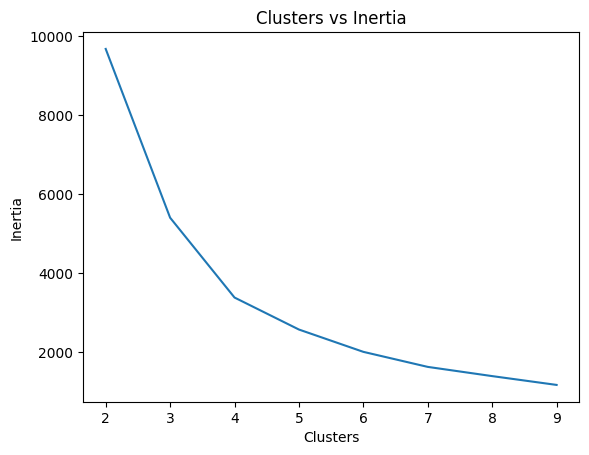

In [75]:
plt.plot(n_clusters, inertia)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.title("Clusters vs Inertia");

**Task 16 :** Visualize the clusters and the silhouette scoress

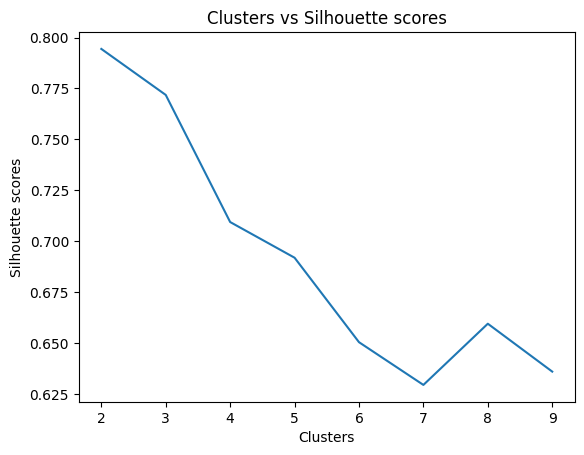

In [104]:
plt.plot(n_clusters, ss_score)
plt.xlabel("Clusters")
plt.ylabel("Silhouette scores")
plt.title("Clusters vs Silhouette scores");

**Comment :** The plots indicate that the best number of cluster is 4

**Task 17 :** Rebuild the model with the best parameters

In [79]:
model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters = 4, random_state = 15)
    )
model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=15))])

# Communicate

**Task 18 :** Print model labels

In [80]:
print("Labels: ", model.named_steps["kmeans"].labels_)

Labels:  [3 0 2 ... 3 3 3]


**Task 19 :** Print model inertia

In [86]:
print("Inertia: ",round(model.named_steps["kmeans"].inertia_, 2))

Inertia:  3390.17


**Task 20 :** Print model silhouette score

In [84]:
print("Silhouette Score: ",round(silhouette_score(X, model.named_steps["kmeans"].labels_), 2))

Silhouette Score:  0.71


**Task 20 :** Generate the centroids

In [88]:
centroid = model.named_steps["kmeans"].cluster_centers_
centroid

array([[-0.69271918,  0.84351763],
       [ 1.2627727 ,  2.68074593],
       [ 1.4239314 ,  0.50358202],
       [-0.67852946, -0.64504474]])

**Task 21:** Create a DataFrame that contains the mean values of the features in the feature columns for each of the clusters in the final model.

In [89]:
X_groupby= X.groupby(model.named_steps["kmeans"].labels_).mean()
X_groupby

,Sub_metering_3,Global_intensity
0,0.338279,8.332789
1,16.485352,16.568945
2,17.816086,6.808884
3,0.455448,1.659676


**Task 22:** Visualize the dataframe on a barchart

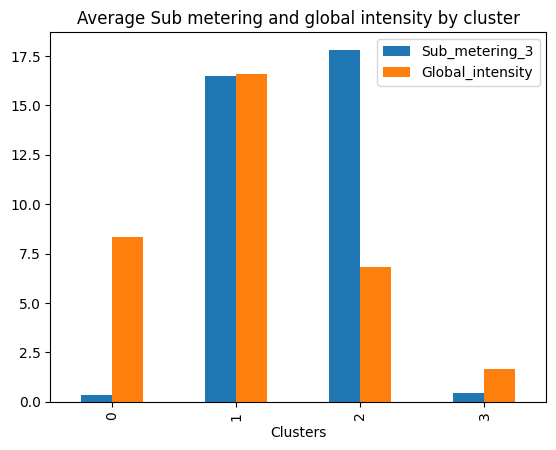

In [105]:
X_groupby.plot(kind = "bar")
plt.xlabel("Clusters")
plt.title("Average Sub metering and global intensity by cluster");

**Task 23:** Visualize the proportion of sub metering to global intensity

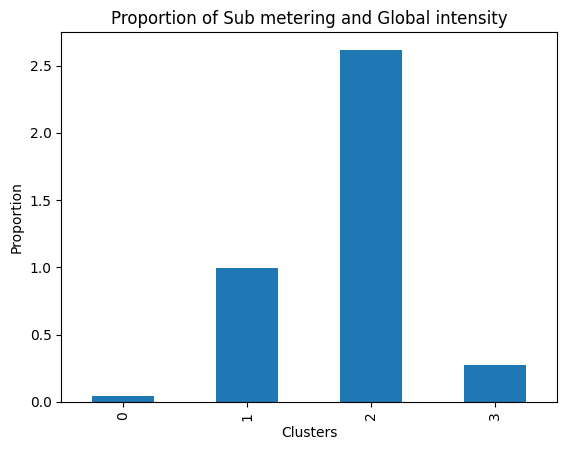

In [99]:
(X_groupby["Sub_metering_3"]/X_groupby["Global_intensity"]).plot(kind = "bar")
plt.xlabel("Clusters")
plt.ylabel("Proportion")
plt.title("Proportion of Sub metering and Global intensity");

# Findings

<font face = "Verdana">
<p>
The finding from the exploration and the model are :<br>
<ul>
<li>The households in clusters 0 and 3 have the least number of sub meters</li>
<li>The households in cluster 2, (closely followed by households in clusters 1) have the highest number of sub meters</li>
<li>The households in cluster 2 has the highest number proportion of sub meters to global intensity</li>
